In [1]:
import numpy as np
import matplotlib.pyplot as plt
from generation import generate_from_total_pdf
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test

def generate_NP_data(n_datapoints, n_attempts, N_range):
    """
    Generate N vs P data

    This function estimates the probability of discovering the signal
    for a range of dataset sizes, by performing Neyman-Pearson 
    hypothesis tests.
    """
    # True parameter values
    true_params, alpha, beta = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}, 5, 5.6

    # Generating starting parameters by adding random shifts to true parameters
    np.random.seed(42)
    random_shifts = {
        'f': np.random.uniform(-0.09, 0.5), 
        'lam': np.random.uniform(-0.3, 0.6), 
        'mu': np.random.uniform(-0.25, 0.3), 
        'sigma': np.random.uniform(-0.01, 0.03)
    }
    starting_params = {}
    for param in true_params:
        starting_params[param] = true_params[param] + random_shifts[param]
        starting_params[param] = float(f'{starting_params[param]:.4}') # rounding to 4 sig. fig.

    # Standard binomial error
    # on estimate of 'probability of discovery'
    def standard_binomial_error(p, n):
        return np.sqrt((p*(1-p))/n)

    # -----------------------------
    # Data Generation and Hypothesis Testing
    # -----------------------------
    N = np.linspace(N_range[0], N_range[1], n_datapoints).astype(int) # values of 'N_events'
    P = [] # probability of discovery
    P_err = [] # error in probability of discovery
    for N_events in N:
        n_i = n_attempts # number of successful hypothesis tests conducted
        discovery_count = 0 # number of 'discoveries'
        for _ in range(n_attempts):

            dataset = generate_from_total_pdf(N_events)

            discovery, _, _ = signal_background_test(
                dataset=dataset, 
                pdf=total_pdf, 
                cdf=total_cdf, 
                starting_params=true_params,
                binned=False, 
                plot=False
                )
            
            # if a valid minimum was not found 
            # then it is not a valid hypothesis test 
            if discovery=='invalid minimum':
                n_i -= 1

            if discovery==True:
                discovery_count += 1

        p = discovery_count/n_i
        P.append(p)
        P_err.append(standard_binomial_error(p, n_i))
        print(f"number of attempts: {n_i}")
        print(f"Sample size (N_events)={N_events}, probability of discovery={P[-1]} +- {P_err[-1]}")

    return np.array(N), np.array(P), np.array(P_err)

In [3]:
from find_NP import generate_NP_data

N, P, P_err = generate_NP_data(n_datapoints=50, n_attempts=500, N_range=(400,900))

print(N, P, P_err)

number of attempts: 500
Sample size (N_events)=400, probability of discovery=0.62 +- 0.021707141681944216
number of attempts: 500
Sample size (N_events)=410, probability of discovery=0.596 +- 0.021944657664224338
number of attempts: 500
Sample size (N_events)=420, probability of discovery=0.654 +- 0.021273645667821018
number of attempts: 500
Sample size (N_events)=430, probability of discovery=0.646 +- 0.021386163751360363
number of attempts: 500
Sample size (N_events)=440, probability of discovery=0.698 +- 0.02053270561811083
number of attempts: 500
Sample size (N_events)=451, probability of discovery=0.74 +- 0.019616319736382767
number of attempts: 500
Sample size (N_events)=461, probability of discovery=0.678 +- 0.020895741192884256
number of attempts: 500
Sample size (N_events)=471, probability of discovery=0.75 +- 0.019364916731037084
number of attempts: 500
Sample size (N_events)=481, probability of discovery=0.728 +- 0.019900552756142227
number of attempts: 500
Sample size (N_ev

NameError: name 'plt' is not defined

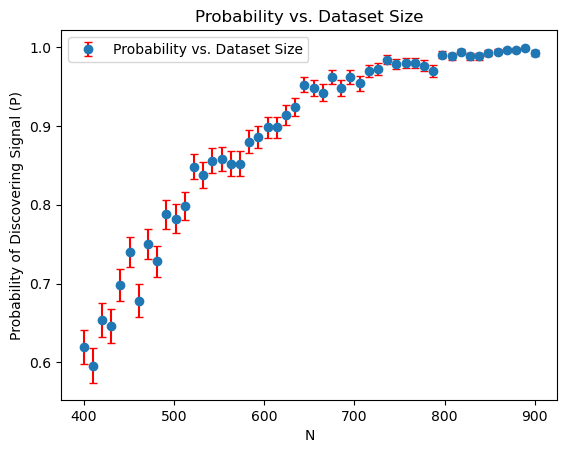

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(N, P, yerr=P_err, fmt='o', ecolor='red', capsize=3, label='Probability vs. Dataset Size')
ax.set_xlabel('N')
ax.set_ylabel('Probability of Discovering Signal (P)')
ax.set_title('Probability vs. Dataset Size')
ax.legend()

In [7]:
import pickle 

data_to_save = {
    'N': N,
    'P': P,
    'P_err': P_err
}

# Save the data to a pickle file
with open('PN_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

In [1]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from generation import generate_from_total_pdf
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test

In [3]:
# True parameter values
true_params, alpha, beta = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}, 5, 5.6
random_shifts = {
    'f': np.random.uniform(-0.09, 0.5), 
    'lam': np.random.uniform(-0.3, 1), 
    'mu': np.random.uniform(-0.25, 0.3), 
    'sigma': np.random.uniform(-0.01, 0.03)
}
starting_params = {}
for param in true_params:
    starting_params[param] = true_params[param] + random_shifts[param]
    starting_params[param] = float(f'{starting_params[param]:.4}')

Sample size (N_events)=500, probability of discovery=0.657 +- 0.015011695440555674
Sample size (N_events)=526, probability of discovery=0.6753507014028056 +- 0.014821994283720304
Sample size (N_events)=552, probability of discovery=0.700502512562814 +- 0.014520778474085538
Sample size (N_events)=578, probability of discovery=0.7394789579158316 +- 0.013893736017233827
Sample size (N_events)=605, probability of discovery=0.7605210420841684 +- 0.013509025656195137
Sample size (N_events)=631, probability of discovery=0.7593152064451159 +- 0.013566279196039761
Sample size (N_events)=657, probability of discovery=0.783 +- 0.013034991369387246
Sample size (N_events)=684, probability of discovery=0.8118712273641852 +- 0.012395898001595223
Sample size (N_events)=710, probability of discovery=0.802 +- 0.012601428490452976
Sample size (N_events)=736, probability of discovery=0.817907444668008 +- 0.0122406641888158
Sample size (N_events)=763, probability of discovery=0.7959798994974875 +- 0.012775

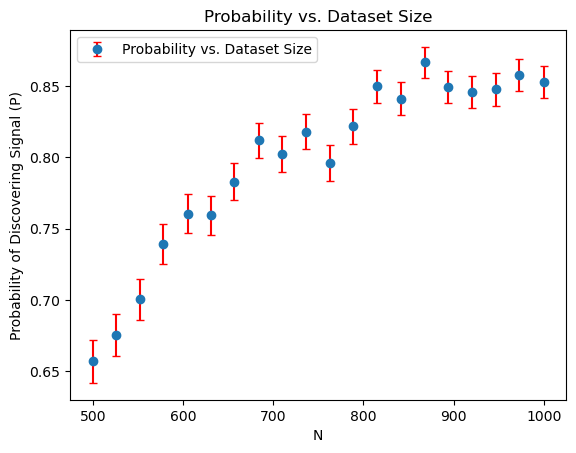

In [4]:
def error_on_p(p, n):
    return np.sqrt((p*(1-p))/n)

n_datapoints = 20
n = 1000
N = np.linspace(500, 1000, n_datapoints).astype(int)
P = []
P_err = []
for N_events in N:
    n_i = n
    discovery_count = 0
    for _ in range(n):

        dataset = generate_from_total_pdf(N_events)

        discovery, _, _ = signal_background_test(
            dataset=dataset, 
            pdf=total_pdf, 
            cdf=total_cdf, 
            starting_params=starting_params,
            binned=False, 
            plot=False
            )
        
        if discovery=='invalid minimum':
            n_i -= 1

        if discovery==True:
            discovery_count += 1

    p = discovery_count/n_i
    P.append(p)
    P_err.append(error_on_p(p, n_i))
    print(f"number of attempts: {n_i}")
    print(f"Sample size (N_events)={N_events}, probability of discovery={P[-1]} +- {P_err[-1]}")
    
N, P, P_err = np.array(N), np.array(P), np.array(P_err)

fig, ax = plt.subplots()
ax.errorbar(N, P, yerr=P_err, fmt='o', ecolor='red', capsize=3, label='Probability vs. Dataset Size')
ax.set_xlabel('N')
ax.set_ylabel('Probability of Discovering Signal (P)')
ax.set_title('Probability vs. Dataset Size')
ax.legend()

In [69]:
n_datapoints = 20
n_init = 1000
N = np.logspace(1, 6, num=n_datapoints).astype(int)
N = np.linspace(500, 1000, n_datapoints).astype(int)

all_data = [np.array([generate_from_total_pdf(N_events) for _ in range(n_init)]) for N_events in N]


In [70]:
len(all_data)

20

Standard binomial error

In [71]:
def error_on_p(p, n):
    return np.sqrt((p*(1-p))/n)

### Hypothesis Testing

In [72]:
from hypothesis_test import signal_background_test

P = []
P_err = []
ns = []
for i, group_i in enumerate(all_data):
    n_i = n_init

    r_discoveries = 0
    for dataset in group_i:

        discovery, _, _ = signal_background_test(
            dataset=dataset, 
            pdf=total_pdf, 
            cdf=total_cdf, 
            starting_params=starting_params,
            binned=False, 
            plot=False
            )

        if discovery=='invalid minimum':
            n_i -= 1

        if discovery==True:
            r_discoveries += 1

    ns.append(n_i)

    p = r_discoveries/n_i
    P.append(p)
    P_err.append(error_on_p(p, n_i))

N, P, P_err = np.array(N), np.array(P), np.array(P_err)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -810.2                     │              Nfcn = 809              │
│ EDM = 2.43 (Goal: 0.0002)        │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

# Finding `N_90`

In [73]:
print(N)
print(P)
print(P_err)

[ 500  526  552  578  605  631  657  684  710  736  763  789  815  842
  868  894  921  947  973 1000]
[0.42       0.4        0.64       0.54       0.52       0.56
 0.72       0.64       0.58       0.76       0.63265306 0.66
 0.52       0.74       0.78       0.76       0.76       0.68
 0.68       0.66      ]
[0.06979971 0.06928203 0.06788225 0.07048404 0.07065409 0.07019972
 0.06349803 0.06788225 0.06979971 0.06039868 0.06886887 0.06699254
 0.07065409 0.06203225 0.05858327 0.06039868 0.06039868 0.06596969
 0.06596969 0.06699254]


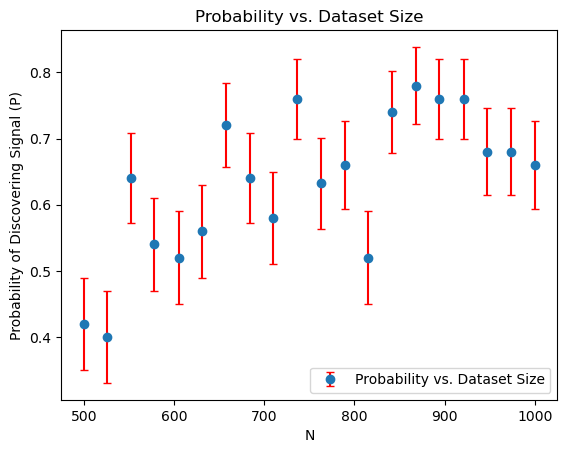

In [74]:
fig, ax = plt.subplots()
ax.errorbar(N, P, yerr=P_err, fmt='o', ecolor='red', capsize=3, label='Probability vs. Dataset Size')
ax.set_xlabel('N')
ax.set_ylabel('Probability of Discovering Signal (P)')
ax.set_title('Probability vs. Dataset Size')
ax.legend()

{'a': '(-2.49e-09, 2.01e-10)',
 'b': '(2.9e-06, 3.05e-07)',
 'c': '(0.000447, 0.000124)',
 'd': '(-0.0306, 0.00916)'}

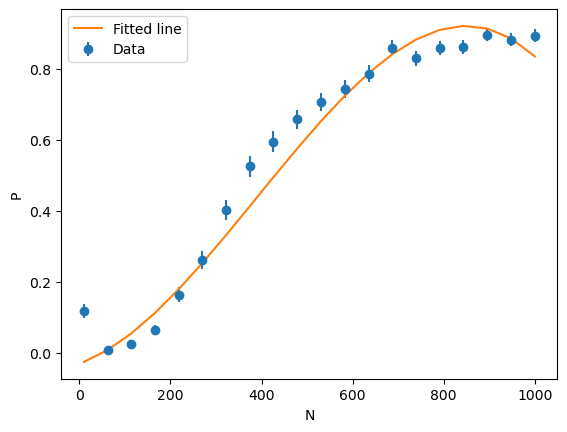

In [25]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def third_degree(x, a, b, c, d):
    return a*(x**3) + b*(x**2) + c*x + d 
def fourth_degree(x, a, b, c, d, e):
    return a*(x**4) + b*(x**3) + c*(x**2) + d*x + e

# Replace 0 uncertainties with 0.00001 so as to 
# not produce errors in the least squares estimation
P_err[P_err == 0.0] = 0.00001

# ------------------
# should maybe use starting values
# ------------------
popt, pcov = curve_fit(third_degree, N, P, sigma=P_err, absolute_sigma=True)

fig, ax = plt.subplots()

# Plotting
ax.errorbar(N, P, yerr=P_err, fmt='o', label='Data')
ax.plot(N, third_degree(N, *popt), label='Fitted line')
ax.set_xlabel('N')
ax.set_ylabel('P')
ax.legend()

a, b, c, d = popt
a_err, b_err, c_err, d_err = np.sqrt(np.diag(pcov))

parameter_estimates = {
    'a': f'({a:.3}, {a_err:.3})',
    'b': f'({b:.3}, {b_err:.3})',
    'c': f'({c:.3}, {c_err:.3})',
    'd': f'({d:.3}, {d_err:.3})'
}

parameter_estimates

In [11]:
# from iminuit import Minuit

# N = reduced_N

# # Define the linear model
# def linear_model(N, m, b):
#     return m * N + b

# # Define the chi-squared function
# def chi2_linear(m, b):
#     return np.sum(((P - linear_model(N, m, b)) / P_err) ** 2)

# # Perform the minimization
# mi = Minuit(chi2_linear, m=3, b=-1)
# mi.limits['b'] = (-3, 1)
# mi.limits['m'] = (1, 20)
# mi.errordef = Minuit.LEAST_SQUARES
# mi.migrad()  # finds minimum of chi-square function

# # Get parameters and errors
# m_fit = mi.values['m']
# b_fit = mi.values['b']
# m_err = mi.errors['m']
# b_err = mi.errors['b']

# # Plotting
# plt.errorbar(N, P, yerr=P_err, fmt='o', label='Data')
# plt.plot(N, linear_model(N, *mi.values), label='Fitted line')
# plt.xlabel('N')
# plt.ylabel('P')
# plt.legend()
# plt.title('Linear Fit of P vs. N')
# plt.show()

# (m_fit, b_fit, m_err, b_err)